In [ ]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import MultiLabelBinarizer   # one-hot encoding
from sklearn.feature_extraction.text import CountVectorizer     # count frequency

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

import time
import matplotlib.pyplot as plt

# path to files
trainingDataFile = "./Train_data.csv"
# trainingDataFile = "./test.csv"
evaluateDataFile = "./Test_data.csv"

# store preprocessing model
encoder = {}

def isFloat(value):
    try:
        float(value)
        return True
    except:
        return False
def isInt(value):
    try:
        int(value)
        return True
    except:
        return False
def groupByLanguage(language):
    # en-US, en-GB, en-CA -> eng
    if language in ['en-US', 'en-GB', 'en-CA']:
        language = 'eng'
    return language

# for training data
def fitTransformByMultiLableBinarizer(trainData, columnName):
    global encoder
    encoder[columnName] = MultiLabelBinarizer()
    temp = trainData[columnName].apply(lambda x: set([" ".join(w.strip().lower().split()) for w in str(x).split("/")]))   # split words by "/" to list, remove duplicated whitespace

    tempValue = encoder[columnName].fit_transform(temp)
    tempColumnName = np.char.add(columnName+"=", encoder[columnName].classes_.tolist())
    
    # concat to original dataframe
    trainData = pd.concat([trainData.drop(columnName, axis=1), pd.DataFrame(tempValue, columns=tempColumnName).set_index(trainData[columnName].index)], axis=1)   
    return trainData

def fitTransformByFrequencyCount(trainData, columnName):
    global encoder
    encoder[columnName] = CountVectorizer()

    tempValue = encoder[columnName].fit_transform(trainData[columnName]).toarray()
    tempColumnName = np.char.add(columnName+"=", encoder[columnName].get_feature_names())

    # concat to original dataframe
    trainData = pd.concat([trainData.drop(columnName, axis=1), pd.DataFrame(tempValue, columns=tempColumnName).set_index(trainData[columnName].index)], axis=1)
    return trainData


# for testing data
def transformByMultiLableBinarizer(testData, columnName):
    global encoder
    temp = testData[columnName].apply(lambda x: set([" ".join(w.strip().lower().split()) for w in str(x).split("/")]))    # split words by "/" to list, remove duplicated whitespace

    tempValue = encoder[columnName].transform(temp)
    tempColumnName = np.char.add(columnName+"=", encoder[columnName].classes_.tolist())
    
    # concat to original dataframe
    testData = pd.concat([testData.drop(columnName, axis=1), pd.DataFrame(tempValue, columns=tempColumnName).set_index(testData[columnName].index)], axis=1)
    return testData

def transformByFrequencyCount(testData, columnName):
    global encoder
    tempValue = encoder[columnName].transform(testData[columnName]).toarray()
    tempColumnName = np.char.add(columnName+"=", encoder[columnName].get_feature_names())

    # concat to original dataframe
    testData = pd.concat([testData.drop(columnName, axis=1), pd.DataFrame(tempValue, columns=tempColumnName).set_index(testData[columnName].index)], axis=1)
    return testData


## Data cleaning

In [ ]:
def dataCleaning(data):
    # remove white spaces of column's name
    data.columns = data.columns.str.strip()

    # remove record if target is not float
    data = data[data['average_rating'].apply(lambda x: isFloat(x))]
    data = data[pd.to_numeric(data['average_rating'])<=5]

    # remove record if value is not integer 
    data = data[data['isbn'].apply(lambda x: isInt(x))]
    data = data[data['num_pages'].apply(lambda x: isInt(x))]
    data = data[data['ratings_count'].apply(lambda x: isInt(x))]
    data = data[data['text_reviews_count'].apply(lambda x: isInt(x))]

    return data

## Preprocess of training data

In [ ]:
def preprocessTrainData(trainData):
    global encoder
    # remove white spaces of column's name
    trainData.columns = trainData.columns.str.strip()

    # if language_code = en-US/en-GB/en-CA -> eng
    trainData['language_code'] = trainData['language_code'].apply(lambda x: groupByLanguage(x))
    
    # split publication_date
    trainData['publication_date'] = pd.to_datetime(trainData['publication_date'], format = "%m/%d/%Y", errors='coerce')
    trainData['publication_date_year'] = trainData['publication_date'].dt.year
    trainData['publication_date_month'] = trainData['publication_date'].dt.month
    trainData['publication_date_week'] = trainData['publication_date'].dt.week
    trainData['publication_date_day'] = trainData['publication_date'].dt.day
    # drop row if one value is null, eg bookID#45531's date = 6/31/1982
    trainData = trainData[trainData.isna().any(axis=1) == False]

    # chage dtype
    trainData = trainData.astype({'title': 'U', 'text_reviews_count': float})

    # drop if duplicated, isbn should be unique
    trainData = trainData[trainData['isbn'].duplicated() == False]

    # drop useless column
    trainData.drop(['isbn', 'isbn13', 'publication_date'], axis=1, inplace=True)

    # one hot encoding of authors & language_code & publisher 
    trainData = fitTransformByMultiLableBinarizer(trainData, 'authors')
    trainData = fitTransformByMultiLableBinarizer(trainData, 'language_code')
    trainData = fitTransformByMultiLableBinarizer(trainData, 'publisher')

    # encode title
    trainData = fitTransformByFrequencyCount(trainData, 'title')

    return trainData.fillna(0)

## Preprocess of testing / predict data

In [ ]:
def preprocessTestData(testData):
    global encoder 
    # remove white spaces of column's name
    testData.columns = testData.columns.str.strip()

    # if language_code = en-US, en-GB, en-CA -> eng
    testData['language_code'] = testData['language_code'].apply(lambda x: groupByLanguage(x))

    # split publication_date
    testData['publication_date'] = pd.to_datetime(testData['publication_date'], format = "%m/%d/%Y", errors='coerce')
    testData['publication_date_year'] = testData['publication_date'].dt.year
    testData['publication_date_month'] = testData['publication_date'].dt.month
    testData['publication_date_week'] = testData['publication_date'].dt.week
    testData['publication_date_day'] = testData['publication_date'].dt.day

    # chage dtype
    testData = testData.astype({'title': 'U', 'text_reviews_count': float})

    # drop useless column
    testData.drop(['isbn', 'isbn13', 'publication_date'], axis=1, inplace=True)


    # one hot encoding of authors & language_code & publisher 
    testData = transformByMultiLableBinarizer(testData, 'authors')
    testData = transformByMultiLableBinarizer(testData, 'language_code')
    testData = transformByMultiLableBinarizer(testData, 'publisher')

    # encode title
    testData = transformByFrequencyCount(testData, 'title')

    return testData.fillna(0)

## Import data
## Split data into train & test

In [ ]:
trainingData = pd.read_csv(trainingDataFile).set_index('bookID')
evaluatingData = pd.read_csv(evaluateDataFile).set_index('bookID')

trainingData = dataCleaning(trainingData)

# spliting data
trainData, testData = train_test_split(trainingData, test_size=0.3, random_state=42)


# preprocessing
trainData = preprocessTrainData(trainData)

testData = preprocessTestData(testData)
evaluateData = preprocessTestData(evaluatingData)

print(f'trainData: {trainData.shape}')
print(f'testData: {testData.shape}')
print(f'evaluateData: {evaluateData.shape}', end='\n\n')
print('Shape checking: ', trainData.shape[1]==testData.shape[1] & trainData.shape[1]==evaluateData.shape[1], end='\n\n\n\n')

def splitXY(data):
    tempX = data.drop('average_rating', axis=1)
    tempY = data['average_rating']
    print(tempX.shape, tempY.shape)
    return tempX, tempY

# split to X, y
XTrain, yTrain = splitXY(trainData)
XTest, yTest = splitXY(testData)
XEvaluate, yEvaluate = splitXY(evaluateData)


# evaluateData.info()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

trainData: (6378, 16197)
testData: (2734, 16197)
evaluateData: (1000, 16197)

Shape checking:  True



(6378, 16196) (6378,)
(2734, 16196) (2734,)
(1000, 16196) (1000,)


## Train Model

In [ ]:
tree = DecisionTreeRegressor(random_state=0)
tree.fit(XTrain, yTrain)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

## Evaluate model

In [ ]:
yPredict = tree.predict(XTest)
mse = mean_squared_error(yTest, yPredict)
print("Regression Tree with frequency count - Mean Squared Error: ", round(mse, 5))


Regression Tree with frequency count - Mean Squared Error:  0.16238


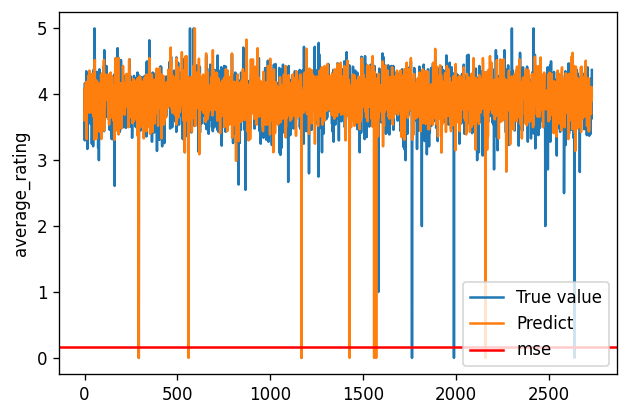

In [ ]:
plt.figure(dpi=120)
plt.plot(yTest.values, label='True value')
plt.plot(yPredict, label='Predict')

plt.axhline(y=mse, color='r', linestyle='-', label='mse')

plt.ylabel('average_rating')
plt.legend()
plt.show()

## Output submit assignment file

In [ ]:
yEvaluatePredict = tree.predict(XEvaluate)

output = evaluatingData
output['average_rating'] = yEvaluatePredict

output.shape
output.head()

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,publication_date_year,publication_date_month,publication_date_week,publication_date_day
bookID,,,,,,,,,,,,,,,
28898,Fundamentals of Heat and Mass Transfer [with I...,Frank P. Incropera/David P. DeWitt,4.27,0470055545,9780470055540,en-US,997,6,0,2006-10-30,Wiley,2006,10,44,30
39358,Stud Rites (A Dog Lover's Mystery #9),Susan Conant,3.73,0425201597,9780425201596,eng,237,322,16,2005-03-01,Berkley Prime Crime Books,2005,3,9,1
32695,El talismán,Stephen King/Peter Straub/Pilar Giralt Gorina,4.02,8408042432,9788408042433,spa,375,12,1,2003-07-01,Planeta Publishing,2003,7,27,1
15096,Five Quarters of the Orange,Joanne Harris,3.90,0060958022,9780060958022,eng,307,26258,1936,2002-06-04,Harper Perennial,2002,6,23,4
15428,Up in a Heaval (Xanth #26),Piers Anthony,3.99,0812574990,9780812574999,eng,342,2364,25,2003-10-19,Tor Fantasy,2003,10,42,19
